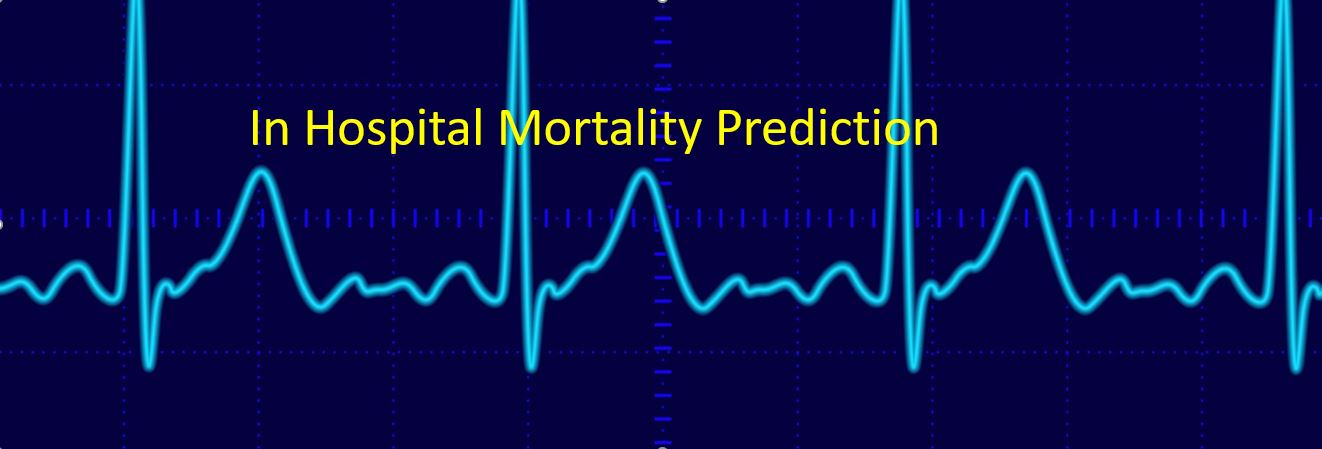

In [1]:
from IPython import display
display.Image('./Hospital Prediction.JPG')

The predictors of in-hospital mortality for intensive care units (ICU)-admitted HF patients remain poorly characterized. We aimed to develop and validate a prediction model for all-cause in-hospital mortality among ICU-admitted HF patients.

we extracted the following data: demographic characteristics (age at the time of hospital admission, sex, ethnicity, weight, and height); vital signs (heart rate, (HR), systolic blood pressure [SBP], diastolic blood pressure [DBP], mean blood pressure, respiratory rate, body temperature, saturation pulse oxygen [SPO2], urine output [first 24 h]); comorbidities (hypertension, atrial fibrillation, ischemic heart disease, diabetes mellitus, depression, hypoferric anemia, hyperlipidemia, chronic kidney disease (CKD), and chronic obstructive pulmonary disease [COPD]); and laboratory variables (hematocrit, red blood cells, mean corpuscular hemoglobin [MCH], mean corpuscular hemoglobin concentration [MCHC], mean corpuscular volume [MCV], red blood cell distribution width [RDW], platelet count, white blood cells, neutrophils, basophils, lymphocytes, prothrombin time [PT], international normalized ratio [INR], NT-proBNP, creatine kinase, creatinine, blood urea nitrogen [BUN] glucose, potassium, sodium, calcium, chloride, magnesium, the anion gap, bicarbonate, lactate, hydrogen ion concentration [pH], partial pressure of CO2 in arterial blood, and LVEF).

The primary outcome of the study was in-hospital mortality, defined as the vital status at the time of hospital discharge in survivors and non-survivors.

In [43]:
import os
import optuna
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

# Classifiers
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


METRIC = f1_score
metric = 'f1_macro'

In [7]:
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org pip catboost

##### Data Exploration

In [44]:
os.chdir(r'H:\Hospital Mortaility Data')

In [45]:
df = pd.read_csv('data01.csv')

In [10]:
df.head()

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [46]:
target = "outcome"
predictors = list(df.columns)
predictors.remove(target)

df

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2,171130,0.0,62,1,25.516870,1,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,2,101659,0.0,78,1,25.822710,0,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,2,162069,0.0,85,2,23.891779,1,1,0,1,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,2,120967,0.0,79,2,35.288554,0,0,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


<AxesSubplot:>

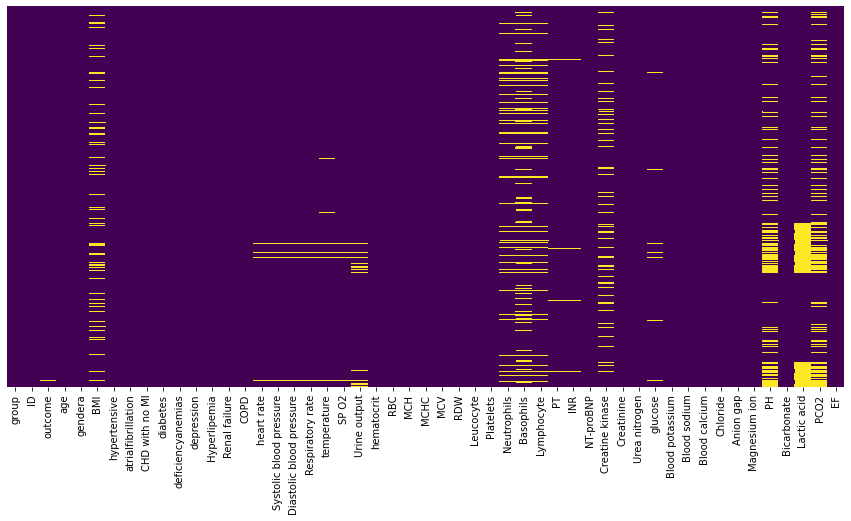

In [47]:
#NaN overview
plt.figure(figsize=(15, 7))
sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [48]:
def NaN_info(df):
    global null_view
    try:
        null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum().sort_values(ascending = True)
        null_view = pd.DataFrame(null_view, columns=['NANs'])
        null_view['PERCENT'] = null_view.NANs.apply(lambda x: round((x/len(df))*100, 2))
        null_view['TYPE'] = df.dtypes
    except:
        return null_view
    return null_view

NaN_info(df)

,NANs,PERCENT,TYPE
outcome,1,0.08,float64
Blood calcium,1,0.08,float64
heart rate,13,1.10,float64
Respiratory rate,13,1.10,float64
SP O2,13,1.10,float64
Systolic blood pressure,16,1.36,float64
Diastolic blood pressure,16,1.36,float64
glucose,18,1.53,float64
temperature,19,1.61,float64
INR,20,1.70,float64


Data Cleaning

1) drop out duplicates
2) drop out columns with 1 unique value
3) drop rows with NaN in the target feature

In [49]:
def trash_cleaner(df, target=None):
    '''drop_duplicates, drop rows with nan in target, drop column with 1 unique value'''
    
    print(f'Start shape: {df.shape}\n')
    print('Drop_duplicates')
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f'shape: {df.shape}\n')
    
    print('Drop columns with 1 unique value')
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop([col], inplace=True, axis=1)
            print(f'column "{col}" cnontain 1 unique value and has been dropped out')
    print(f'shape: {df.shape}\n')
            
    
    if target:
        print('Drop rows with NaN in target feature')
        nan = df[df[target].isnull()]
        indeces = list(nan.index)
        print(f'number of rows with NaN in target feature:\
        {len(indeces)} rows have been dropped out\n')
        df = df.drop(df.index[indeces])
        df.reset_index(drop=True, inplace=True)
        
        print(f'Finish shape: {df.shape}\n')
    
    return df

In [50]:
df = trash_cleaner(df, target)

Start shape: (1177, 51)

Drop_duplicates
shape: (1177, 51)

Drop columns with 1 unique value
shape: (1177, 51)

Drop rows with NaN in target feature
number of rows with NaN in target feature:        1 rows have been dropped out

Finish shape: (1176, 51)



In [51]:
df=df.drop(['group','ID'],axis=1)

In [53]:
df.head()

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0.0,72,1,37.588179,0,0,0,1,1,0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,0.0,75,2,NaN,0,0,0,0,1,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,0.0,83,2,26.572634,0,0,0,0,1,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,0.0,43,2,83.264629,0,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,0.0,75,2,31.824842,1,0,0,0,1,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [54]:
df.dtypes

outcome                     float64
age                           int64
gendera                       int64
BMI                         float64
hypertensive                  int64
atrialfibrillation            int64
CHD with no MI                int64
diabetes                      int64
deficiencyanemias             int64
depression                    int64
Hyperlipemia                  int64
Renal failure                 int64
COPD                          int64
heart rate                  float64
Systolic blood pressure     float64
Diastolic blood pressure    float64
Respiratory rate            float64
temperature                 float64
SP O2                       float64
Urine output                float64
hematocrit                  float64
RBC                         float64
MCH                         float64
MCHC                        float64
MCV                         float64
RDW                         float64
Leucocyte                   float64
Platelets                   

In [57]:
df.dropna(subset=['outcome'])

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0.0,72,1,37.588179,0,0,0,1,1,0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,0.0,75,2,NaN,0,0,0,0,1,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,0.0,83,2,26.572634,0,0,0,0,1,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,0.0,43,2,83.264629,0,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,0.0,75,2,31.824842,1,0,0,0,1,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.0,62,1,25.516870,1,1,0,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1172,0.0,78,1,25.822710,0,1,0,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1173,0.0,85,2,23.891779,1,1,0,1,1,0,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1174,0.0,79,2,35.288554,0,0,1,1,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


In [58]:
def NaN_info(df):
    global null_view
    try:
        null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum().sort_values(ascending = True)
        null_view = pd.DataFrame(null_view, columns=['NANs'])
        null_view['PERCENT'] = null_view.NANs.apply(lambda x: round((x/len(df))*100, 2))
        null_view['TYPE'] = df.dtypes
    except:
        return null_view
    return null_view

NaN_info(df)

,NANs,PERCENT,TYPE
Blood calcium,1,0.09,float64
heart rate,12,1.02,float64
Respiratory rate,12,1.02,float64
SP O2,12,1.02,float64
Systolic blood pressure,15,1.28,float64
Diastolic blood pressure,15,1.28,float64
glucose,17,1.45,float64
temperature,18,1.53,float64
PT,20,1.70,float64
INR,20,1.70,float64


In [60]:
# Replace the NaNs in column S2 & S3 by the mean of values
# in column S2 & S3 respectively
columns=['Blood calcium','heart rate','Respiratory rate','SP O2','Systolic blood pressure','Diastolic blood pressure','glucose',
        'temperature', 'PT','INR', 'Urine output','Neutrophils','Lymphocyte','Creatine kinase','BMI','Lactic acid','Basophils','PH','PCO2']
df[columns] = df[columns].fillna(value=df[columns].mean())

<AxesSubplot:>

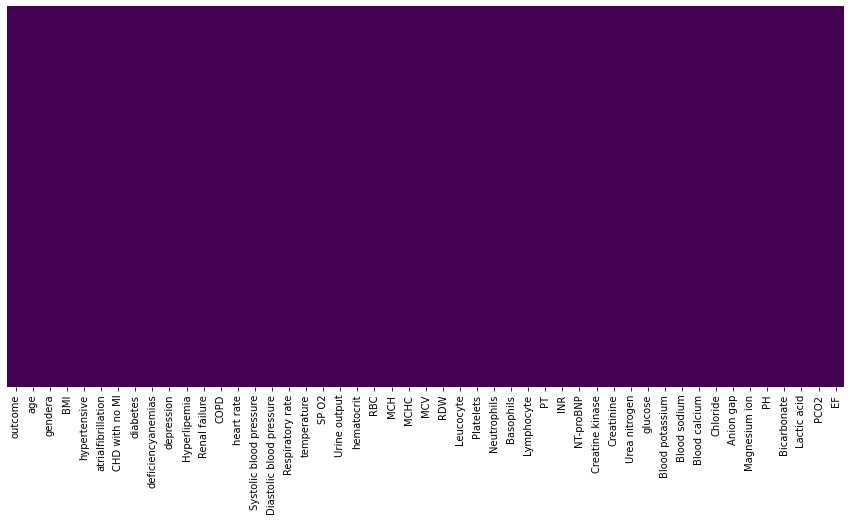

In [62]:
#NaN overview
plt.figure(figsize=(15, 7))
sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='viridis')

We have imbalanced target feature

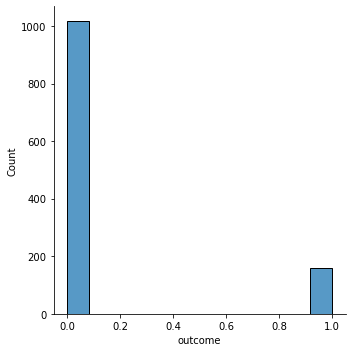

In [65]:
sns.displot(data=df, x=target)

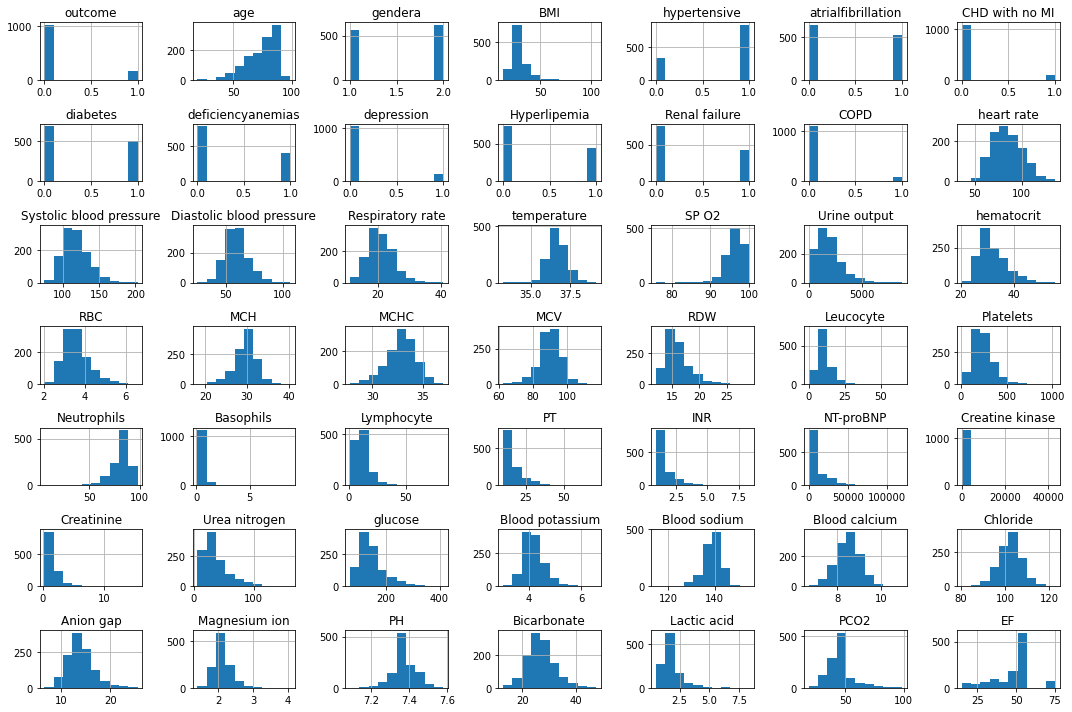

In [69]:
#Overview the variables
df.hist(bins=10, figsize=(15, 10))
plt.tight_layout()

In [70]:
df.corr()

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
outcome,1.000000,0.064510,-0.022690,-0.053076,-0.072441,0.100975,-0.014694,-0.049997,-0.099513,-0.060883,...,-0.066366,-0.184059,0.059834,0.229676,0.074033,-0.140239,-0.222650,0.215853,-0.046357,-0.024138
age,0.064510,1.000000,0.082355,-0.349928,0.176768,0.291674,0.037776,-0.089836,0.015511,-0.094358,...,0.105644,-0.008923,0.139260,-0.004764,0.088651,0.095204,-0.061097,0.005679,-0.109724,0.054138
gendera,-0.022690,0.082355,1.000000,0.022236,0.009342,-0.037798,-0.079474,-0.034932,0.080283,0.081129,...,0.022804,0.059657,0.001392,-0.047598,-0.034438,-0.065826,0.036335,0.007712,0.074005,0.172472
BMI,-0.053076,-0.349928,0.022236,1.000000,-0.028936,-0.107449,-0.057501,0.141277,-0.018911,0.022985,...,0.044804,0.086029,-0.167219,-0.112042,0.015525,-0.105224,0.263997,-0.079839,0.284118,0.053923
hypertensive,-0.072441,0.176768,0.009342,-0.028936,1.000000,0.007244,0.010205,0.129122,-0.005415,-0.043612,...,0.034395,0.081110,-0.017357,0.067240,0.000870,0.020656,0.011079,-0.019560,-0.007093,0.012440
atrialfibrillation,0.100975,0.291674,-0.037798,-0.107449,0.007244,1.000000,-0.003687,-0.012140,-0.098022,-0.059171,...,-0.028091,0.018085,0.021955,0.050194,0.067061,0.041571,-0.071900,0.044013,-0.089002,0.011550
CHD with no MI,-0.014694,0.037776,-0.079474,-0.057501,0.010205,-0.003687,1.000000,0.009142,0.043152,0.046633,...,-0.071736,0.020915,-0.057409,0.024923,0.016787,0.061270,-0.009370,0.010017,-0.060051,-0.146165
diabetes,-0.049997,-0.089836,-0.034932,0.141277,0.129122,-0.012140,0.009142,1.000000,0.062037,0.005698,...,0.032411,0.079859,-0.026699,0.036929,0.018225,-0.019816,0.044081,0.031144,0.058967,-0.026165
deficiencyanemias,-0.099513,0.015511,0.080283,-0.018911,-0.005415,-0.098022,0.043152,0.062037,1.000000,0.063777,...,-0.009583,-0.049631,0.063917,-0.016079,0.025042,0.008418,-0.059122,-0.104007,-0.067666,-0.031308
depression,-0.060883,-0.094358,0.081129,0.022985,-0.043612,-0.059171,0.046633,0.005698,0.063777,1.000000,...,-0.028781,0.010262,-0.023125,-0.014536,-0.081614,0.070449,0.005960,-0.002733,-0.058815,-0.031101


In [73]:
all_cols = df.columns
selected_cols = [ 'age', 'gendera', 'BMI', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF']

In [74]:
X_main = df.iloc[:][selected_cols]
y_main = df['outcome']

X_main.head()

,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,72,1,37.588179,0,0,0,1,1,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,75,2,30.188278,0,0,0,0,1,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,83,2,26.572634,0,0,0,0,1,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,43,2,83.264629,0,0,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,75,2,31.824842,1,0,0,0,1,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, 
                                                  test_size=0.2,
                                                   shuffle=True,
                                                   random_state= 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25)

X_main.shape, X_train.shape

((1176, 48), (705, 48))

In [77]:
training_shapes = X_train.shape[0], y_train.shape[0], X_val.shape[0], y_val.shape[0], X_test.shape[0], y_test.shape[0]
training_shapes2 = pd.DataFrame(training_shapes, columns = ['Test Splits'], index=(['X_train','y_train','X_val','y_val','X_test','y_test']))
training_shapes2.head(6)

,Test Splits
X_train,705
y_train,705
X_val,235
y_val,235
X_test,236
y_test,236


In [78]:
selected_cols_binary = ['gendera', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD']

In [79]:
selected_cols_float = [ 'age', 'BMI', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF']

In [80]:
X_train.iloc[:][selected_cols_binary]

,gendera,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD
1097,1,1,1,0,1,1,0,1,0,0
201,2,1,1,0,0,0,0,0,1,0
750,1,1,0,0,0,1,0,0,1,0
324,1,1,1,0,1,0,0,1,0,0
1110,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
517,1,1,1,0,0,0,1,1,0,0
943,2,0,0,0,0,1,1,0,0,0
281,1,1,0,0,0,1,0,1,0,0
21,2,1,0,0,1,0,0,0,0,0


In [82]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([
    ('simple_impute_binary',SimpleImputer(strategy = 'most_frequent'),selected_cols_binary),
    #('one_hot_encode',OneHotEncoder(drop='first'), selected_cols_binary),
    ('simple_impute_float',SimpleImputer(),selected_cols_float),
])

In [83]:
X_train_FE = ct.fit_transform(X_train)
X_test_FE = ct.transform(X_test)
X_val_FE = ct.transform(X_val)

In [84]:
X_train_FE.shape

(705, 48)

In [85]:
# There is an NAN value, we replace it with the MODE of the set, which is 0
y_train.fillna(value=0,inplace=True)

##### Random Forest

In [87]:
from sklearn.model_selection import KFold
# penalizes error in minority class
tree_classif = RandomForestClassifier()

tree_classif.fit(X_train_FE,y_train)

y_val.fillna(value=0,inplace=True)


# Cross validation:
kf = KFold(n_splits=10)
cross_accuracy = cross_val_score(tree_classif,X_train_FE,y_train,cv=kf,scoring='precision')

# high variancy -> more data for training set
cross_accuracy



array([1. , 1. , 0. , 0.5, 1. , 1. , 0. , 1. , 0. , 0. ])

##### XGB Classifier with In-Training Dataset Balancing

In [110]:
# 'reg:squarederror'
# Used log regression for this classification problem 
# Set slpha to 8(Lasso regression) to penalize errors in the minority class
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', learning_rate = 0.1,
                max_depth = 13, alpha = 8,random_state=42)

In [111]:
xg_reg.fit(X_train_FE,y_train)

kf2 = KFold(n_splits=10)

scores = cross_val_score(xg_reg, X_test_FE, y_test, cv = kf2)

scores

array([0.91666667, 0.875     , 0.79166667, 0.75      , 0.875     ,
       0.83333333, 0.86956522, 0.69565217, 0.95652174, 0.7826087 ])

[[193   3]
 [ 35   5]]


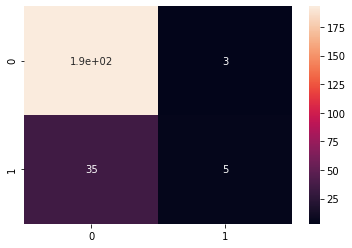

In [112]:
ypred = xg_reg.predict(X_test_FE)
cm = confusion_matrix(y_test,ypred) 
sns.heatmap(cm, annot=True)
print(cm)


In [94]:
precision_xg = metrics.precision_score(y_test,ypred,pos_label=1)
print(precision_xg)

0.625


In [95]:
cm2 = metrics.recall_score(y_test,ypred,pos_label=1)
print(cm2)

0.125


In [96]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

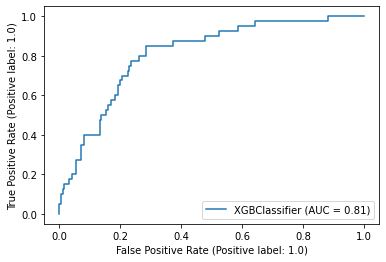

In [97]:
_=plot_roc_curve(xg_reg, X_test_FE, y_test)

##### Logistic Regression

In [103]:
# build a model

log = LogisticRegression(solver = "liblinear")
log_model = log.fit(X_train, y_train)
log_model

LogisticRegression(solver='liblinear')

In [106]:
#Accuracy Score of Model on Test Set
y_pred = log_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8686440677966102

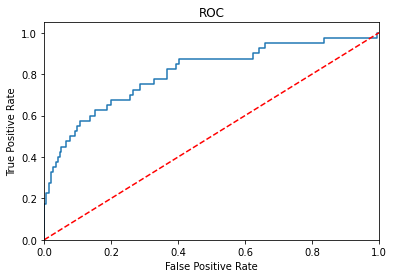

In [107]:
#ROC AUC - Logistic Regression
log_roc_auc = roc_auc_score(y_test, log_model.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, log_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'AUC (area = %0.2f)' % log_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

[[192   4]
 [ 27  13]]


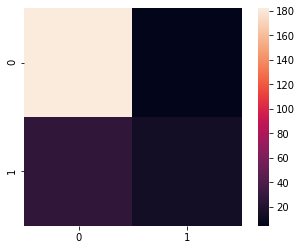

In [108]:
#Confusion Matrix Visualization
# Visualization Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

# Visualize it as a heatmap
import seaborn
seaborn.heatmap(conf_mat, square = True, robust = True)
plt.show()